# Случайный лес. Домашнее задание.

## Подготовка данных

Данные, с которыми мы сегодня работаем взяты из соревнования по предсказанию стоимости недвижимости от Сбербанка: https://www.kaggle.com/c/sberbank-russian-housing-market

**Задача**: по характеристикам объекта недвижимости предсказать его стоимость

**Тип**: регрессия

Загрузим и посмотрим на данные

In [1]:
import pandas as pd


data = pd.read_csv('./data/house_pricing.csv')

# Сразу удаляем поле с идентификатором
data.drop(columns='id', inplace=True)
data.head()

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
2,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
3,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
4,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452


In [2]:
data.shape

(30471, 291)

Смотрим из каких полей состоят данные:

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30471 entries, 0 to 30470
Columns: 291 entries, timestamp to price_doc
dtypes: float64(119), int64(156), object(16)
memory usage: 67.7+ MB


Числовые признак - те, что имеют типа integer и float, категориальные - все остальные

In [4]:
numerical_features = list(data.columns[(data.dtypes == 'float64') | (data.dtypes == 'int64')])
categorical_features = list(data.columns[data.dtypes == object])

Посмотрим внимательно на категориальные признаки:

In [5]:
data[categorical_features].head()

,timestamp,product_type,sub_area,culture_objects_top_25,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,water_1line,big_road1_1line,railroad_1line,ecology
0,2011-08-20,Investment,Bibirevo,no,no,no,no,no,no,no,no,no,no,no,no,good
1,2011-08-23,Investment,Nagatinskij Zaton,yes,no,no,no,no,no,no,no,no,no,no,no,excellent
2,2011-08-27,Investment,Tekstil'shhiki,no,no,no,no,yes,no,no,no,no,no,no,no,poor
3,2011-09-01,Investment,Mitino,no,no,no,no,no,no,no,no,no,no,no,no,good
4,2011-09-05,Investment,Basmannoe,no,no,no,no,yes,yes,no,no,no,no,no,yes,excellent


Можем заменить no/yes на 0/1, таким образом часть категориальных признаков станут числовыми:

In [6]:
data = data.replace(['no', 'yes'], [0, 1])

In [7]:
categorical_features = list(data.columns[data.dtypes == object])
categorical_features.remove('timestamp')
numerical_features = list(data.columns[(data.dtypes == 'float64') | (data.dtypes == 'int64')])

In [8]:
data[numerical_features].isna().mean(axis=0)

full_sq               0.000000
life_sq               0.209478
floor                 0.005481
max_floor             0.314135
material              0.314135
                        ...   
mosque_count_5000     0.000000
leisure_count_5000    0.000000
sport_count_5000      0.000000
market_count_5000     0.000000
price_doc             0.000000
Length: 287, dtype: float64

В вещественных признаках было много пропусков, заполним их средним арифметическим по каждому полю:

In [9]:
data[numerical_features] = data[numerical_features].fillna(data[numerical_features].mean(axis=0))

Посмотрим на оставшиеся категориальные признаки:

In [10]:
data[categorical_features].head()

,product_type,sub_area,ecology
0,Investment,Bibirevo,good
1,Investment,Nagatinskij Zaton,excellent
2,Investment,Tekstil'shhiki,poor
3,Investment,Mitino,good
4,Investment,Basmannoe,excellent


Местоположение недвижимости имеет следующие значения:

In [11]:
area_stat = data['sub_area'].value_counts()
area_stat

Poselenie Sosenskoe               1776
Nekrasovka                        1611
Poselenie Vnukovskoe              1372
Poselenie Moskovskij               925
Poselenie Voskresenskoe            713
                                  ... 
Molzhaninovskoe                      3
Poselenie Shhapovskoe                2
Poselenie Kievskij                   2
Poselenie Klenovskoe                 1
Poselenie Mihajlovo-Jarcevskoe       1
Name: sub_area, Length: 146, dtype: int64

In [12]:
data['sub_area'] = data['sub_area'].apply(lambda x: x if area_stat[x] >= 300 else 'Other')
print(f'Number of unique areas is {data["sub_area"].nunique()}')

Number of unique areas is 22


Поля product_type и ecology не требуют дополнительной обработки перед кодированием:

In [13]:
data['product_type'].value_counts(dropna=False)

Investment       19448
OwnerOccupier    11023
Name: product_type, dtype: int64

In [14]:
data['ecology'].value_counts(dropna=False)

poor            8018
no data         7656
good            7174
excellent       3938
satisfactory    3685
Name: ecology, dtype: int64

Нам повезло, поскольку в категориальных признаках нет пропусков:

In [15]:
data[categorical_features].isna().mean(axis=0)

product_type    0.0
sub_area        0.0
ecology         0.0
dtype: float64

Посчитаем итоговое суммарное количество уникальных значение закодированных категориальных признаков

In [17]:
number_of_categorical = sum([data[field].nunique(dropna=False) for field in categorical_features])
number_of_categorical

29

Кодируем категориальные признаки с помощью one-hot-encoding:

In [18]:
from sklearn.preprocessing import OneHotEncoder


encoder = OneHotEncoder()
encoder.fit(data[categorical_features])
categories = []
for i, feature in enumerate(categorical_features):
    categories.extend([f'{feature}: {value}' for value in encoder.categories_[i]])
data.loc[:, categories] = encoder.transform(data[categorical_features]).toarray().astype(int)

/var/folders/wb/r313lqxj0blcb_3d4p6nv5zw0000gn/T/ipykernel_1118/3654389271.py:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:, categories] = encoder.transform(data[categorical_features]).toarray().astype(int)


В итоге мы привели категориальные признаки к следующему виду:

In [19]:
categories

['product_type: Investment',
 'product_type: OwnerOccupier',
 'sub_area: Bogorodskoe',
 'sub_area: Izmajlovo',
 'sub_area: Juzhnoe Butovo',
 'sub_area: Krjukovo',
 "sub_area: Mar'ino",
 'sub_area: Mitino',
 'sub_area: Nagatinskij Zaton',
 'sub_area: Nagornoe',
 'sub_area: Nekrasovka',
 'sub_area: Other',
 'sub_area: Otradnoe',
 'sub_area: Poselenie Desjonovskoe',
 'sub_area: Poselenie Filimonkovskoe',
 'sub_area: Poselenie Moskovskij',
 'sub_area: Poselenie Shherbinka',
 'sub_area: Poselenie Sosenskoe',
 'sub_area: Poselenie Vnukovskoe',
 'sub_area: Poselenie Voskresenskoe',
 'sub_area: Solncevo',
 'sub_area: Strogino',
 'sub_area: Tverskoe',
 'sub_area: Zapadnoe Degunino',
 'ecology: excellent',
 'ecology: good',
 'ecology: no data',
 'ecology: poor',
 'ecology: satisfactory']

## Обучение модели

Делим данные на обучение и тест:

In [20]:
from sklearn.model_selection import train_test_split


features = numerical_features + categories
features.remove('price_doc')
X = data[features]
y = data['price_doc']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=24)

Обучаем случайный лес с большим количеством деревьев:

In [21]:
%%time
from sklearn.ensemble import RandomForestRegressor


model = RandomForestRegressor(n_estimators=500, n_jobs=4, verbose=1, oob_score=True,
                              max_features=X_train.shape[1] // 3)
model.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   48.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  2.2min finished


CPU times: user 8min 32s, sys: 3.61 s, total: 8min 36s
Wall time: 2min 14s


RandomForestRegressor(max_features=105, n_estimators=500, n_jobs=4,
                      oob_score=True, verbose=1)

Для удобства создаем функцию, которая будет возвращать метрики сразу на обучающих и тестовых данных:

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np


def get_metrics(model, digits=0):
    results = []
    y_pred = model.predict(X_train)
    mae = mean_absolute_error(y_train, y_pred)
    mse = mean_squared_error(y_train, y_pred)
    r2 = r2_score(y_train, y_pred)
    results.append(['Train', mae, mse, r2 * 100])
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append(['Test', mae, mse, r2 * 100])
    return np.round(pd.DataFrame(columns=['Group', 'MAE', 'MSE', 'R2'], data=results), digits)

In [23]:
get_metrics(model)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.5s finished


,Group,MAE,MSE,R2
0,Train,522953.0,1.073548e+12,95.0
1,Test,1397777.0,7.241020e+12,69.0


Out-of-bag метрики очень близки к метрикам на тестовых данных

In [24]:
print(f'OOB MAE: {np.round(mean_absolute_error(y_train, model.oob_prediction_))}')
print(f'OOB MSE: {np.round(mean_squared_error(y_train, model.oob_prediction_)):.02e}')

OOB MAE: 1410644.0
OOB MSE: 7.71e+12


Посмотрим как меняется метрика MAE в зависимости от количества деревьев:

In [25]:
%%time
pred_train = np.hstack((estimator.predict(X_train.values).reshape((-1 , 1)) for estimator in model.estimators_))
pred_test = np.hstack((estimator.predict(X_test.values).reshape((-1 , 1)) for estimator in model.estimators_))

<timed exec>:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
<timed exec>:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


CPU times: user 21.1 s, sys: 3.73 s, total: 24.8 s
Wall time: 25 s


In [26]:
mae = {'Train': [], 'Test': []}
for i in range(1, pred_train.shape[1]):
    mae['Train'].append(mean_absolute_error(y_train, pred_train[:, :i].mean(axis=1)))
for i in range(1, pred_train.shape[1]):
    mae['Test'].append(mean_absolute_error(y_test, pred_test[:, :i].mean(axis=1)))

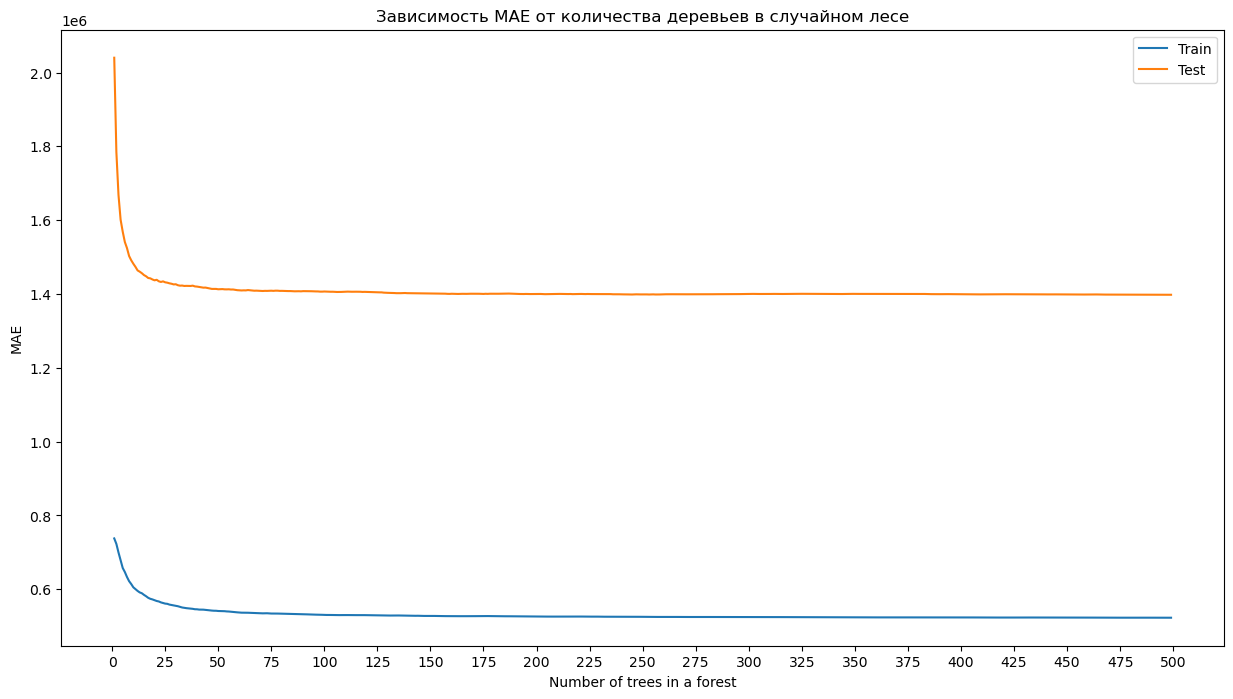

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))
plt.plot(range(1, pred_train.shape[1]), mae['Train'], label='Train')
plt.plot(range(1, pred_test.shape[1]), mae['Test'], label='Test')
plt.xticks(ticks=np.arange(0, pred_train.shape[1] + 1, 25))
plt.title('Зависимость MAE от количества деревьев в случайном лесе')
plt.xlabel('Number of trees in a forest')
plt.ylabel('MAE')
plt.legend()
plt.show()

Убедимся в том, что достаточно 100 деревьев:

In [28]:
model = RandomForestRegressor(n_estimators=150, n_jobs=4, verbose=1, oob_score=True)
model.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   33.8s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:  2.1min finished


RandomForestRegressor(n_estimators=150, n_jobs=4, oob_score=True, verbose=1)

In [29]:
get_metrics(model)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.2s finished


,Group,MAE,MSE,R2
0,Train,532593.0,1.096927e+12,95.0
1,Test,1411512.0,7.200052e+12,69.0


## Бонус случайного леса

Выведем признаки с наибольшей важностью

In [30]:
pd.DataFrame(data={'feature': features, 
                   'importance': model.feature_importances_}).sort_values('importance', ascending=False).iloc[:10]

,feature,importance
0,full_sq,0.393604
277,cafe_count_5000_price_2500,0.035530
246,cafe_count_3000,0.029673
223,cafe_count_2000,0.022067
254,cafe_count_3000_price_2500,0.020720
253,cafe_count_3000_price_1500,0.017955
261,sport_count_3000,0.017345
266,office_sqm_5000,0.010735
104,ttk_km,0.009755
231,cafe_count_2000_price_2500,0.009688
